# Module 2: AI Algorithm (Machine Learning Model, Training, Tuning, Evaluation and Selection)

For the second module, the following has been done:
#### 1. Model Selection
- Choose a set of machine learning models to evaluate the data, and split the data into training and testing sets. The following models were selected:
    - Logistic Regression
    - Decision Trees
    - Random Forest
    - Gradient Boosting
    - Support Vector Machine
    - XGBoost
    - Voting Classifier
#### 2. Model Training 
- Train multiple models and evaluate their performance using cross-validation, using appropriate metrics such as accuracy, precision, recall, F1-score, ROC-AUC
#### 3. Model Tuning:
- Perform hyperparameter tuning using techniques such as Grid Search or Random Search, and select the best model based on performance metrics
#### 4. Model Evaluation:
- Evaluate the final model on the test set
- Generate a classification report and confusion matrix
- Plot ROC and Precision Recall Curves
#### 5. Model Interpretation:
- Interpret the model's predictions using techniques like SHAP (SSapley Additive exPlanations) values. 
- Identify the most important features driving the predictions.

In [2]:
# Import libraries
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import tabulate
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve

In [3]:
# Loading the Data Frame
df = pd.read_csv('../data/processed_data_ml_model.csv')
df

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,Churn
0,0,1,0,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,34,1,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,0,0,0,2,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,1,1
3,0,0,0,45,0,0,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
4,0,0,0,2,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10321,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,1
10322,1,0,0,1,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,1
10323,0,0,0,9,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,1
10324,0,0,0,69,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


**Splitting the data into training and testing sets**

In [4]:
eval_scores = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
cross_val_scores = pd.DataFrame(columns=['Model', 'CV - Accuracy', 'CV - Precision', 'CV - Recall', 'CV - F1', 'CV - ROC AUC'])
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8260, 27), (2066, 27), (8260,), (2066,))

**Functions to evaluate any given model, and provide plots for any given model**

In [5]:
def evaluate_model(model, X_test, y_test, cv=5):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    cross_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    cross_precision = cross_val_score(model, X, y, cv=5, scoring='precision').mean()
    cross_recall = cross_val_score(model, X, y, cv=5, scoring='recall').mean()
    cross_f1 = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
    cross_roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()


    table_data = [
        ["Metric", "Single Value", "Cross Validation"],
        ["Accuracy", accuracy, cross_accuracy],
        ["Precision", precision, cross_precision],
        ["Recall", recall, cross_recall],
        ["F1 Score", f1, cross_f1],
        ["ROC AUC", roc_auc, cross_roc_auc]
    ]

    print(tabulate.tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

    return y_pred, y_prob, table_data

def plot_evaluation(y_test, y_prob, y_pred, model_name):
    # Classification report
    print(f"Classification Report for {model_name}")
    print(classification_report(y_test, y_pred))

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    fig.suptitle(f"{model_name}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix).plot(ax=axes[0], values_format='d', cmap='Blues')
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    axes[0].grid(False)

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, label=model_name)
    axes[1].plot([0, 1], [0, 1], 'k--'); axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate'); axes[1].set_title('ROC Curve'); axes[1].legend()
    axes[1].grid(True)

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    axes[2].plot(recall, precision, label=model_name)
    axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision'); axes[2].set_title('Precision-Recall Curve'); axes[2].legend()
    axes[2].grid(True)

def compare_models(model1_scores, model2_scores):
    # Unpack scores
    model1_name, acc1, prec1, rec1, f11, roc_auc1, cv_acc1, cv_prec1, cv_rec1, cv_f11, cv_roc_auc1 = model1_scores
    model2_name, acc2, prec2, rec2, f12, roc_auc2, cv_acc2, cv_prec2, cv_rec2, cv_f12, cv_roc_auc2 = model2_scores

    # Calculate the mean scores for model1 and model2
    mean_scores1 = (acc1 + prec1 + rec1 + f11 + roc_auc1 + cv_acc1 + cv_prec1 + cv_rec1 + cv_f11 + cv_roc_auc1) / 10
    mean_scores2 = (acc2 + prec2 + rec2 + f12 + roc_auc2 + cv_acc2 + cv_prec2 + cv_rec2 + cv_f12 + cv_roc_auc2) / 10

    # Compare mean scores
    if mean_scores1 >= mean_scores2: return f"{model1_name} Performs better"
    else: return f"{model2_name} Performs better"

### 1. Logistic Regression Model

**Training the model**

In [6]:
logreg = LogisticRegression(max_iter=1000, random_state=200)
logreg.fit(X_train, y_train)

/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=200)

**Evaluate the performance of the model based on various metrics**
- **Accuracy, precision, recall, f1-score, ROC-AUC**
- **Generating Classification Report**
- **Confusion Matrix**
- **ROC Curve and Precision-Recall Curve**

In [7]:
y_pred, y_prob, table_data = evaluate_model(logreg, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.843175 │           0.831505 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.849409 │           0.851014 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.834623 │           0.803016 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.841951 │           0.81178  │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.843184 │           0.931525 │
╘═══════════╧════════════════╧════════════════════╛


/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Hyperparameter Tuning using GridSearch CV**

In [8]:
# Define the parameter grid for Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=200), param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print('Best Parameters:', grid_search.best_params_)

# Tuned Estimator
logreg_tuned = grid_search.best_estimator_

/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Best Parameters: {'C': 10, 'solver': 'newton-cg'}


In [9]:
y_pred_best, y_prob_best, table_data = evaluate_model(logreg_tuned, X_test, y_test)

a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.843659 │           0.830441 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.852329 │           0.853046 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.831721 │           0.797593 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.841899 │           0.808284 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.843671 │           0.932601 │
╘═══════════╧════════════════╧════════════════════╛


Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1032
           1       0.85      0.83      0.84      1034

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066

Classification Report for Logistic Regression (Tuned)
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1032
           1       0.85      0.83      0.84      1034

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066



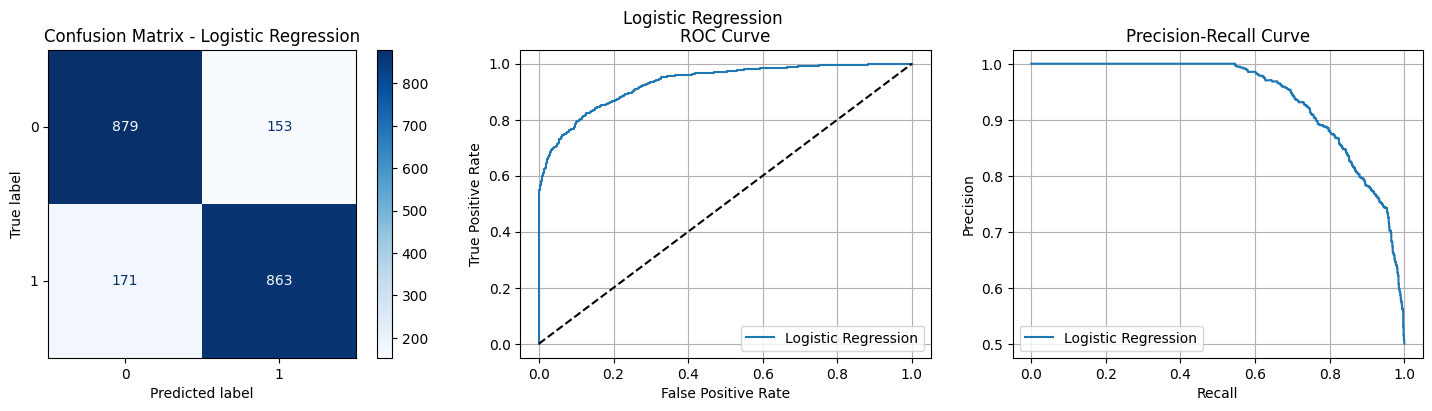

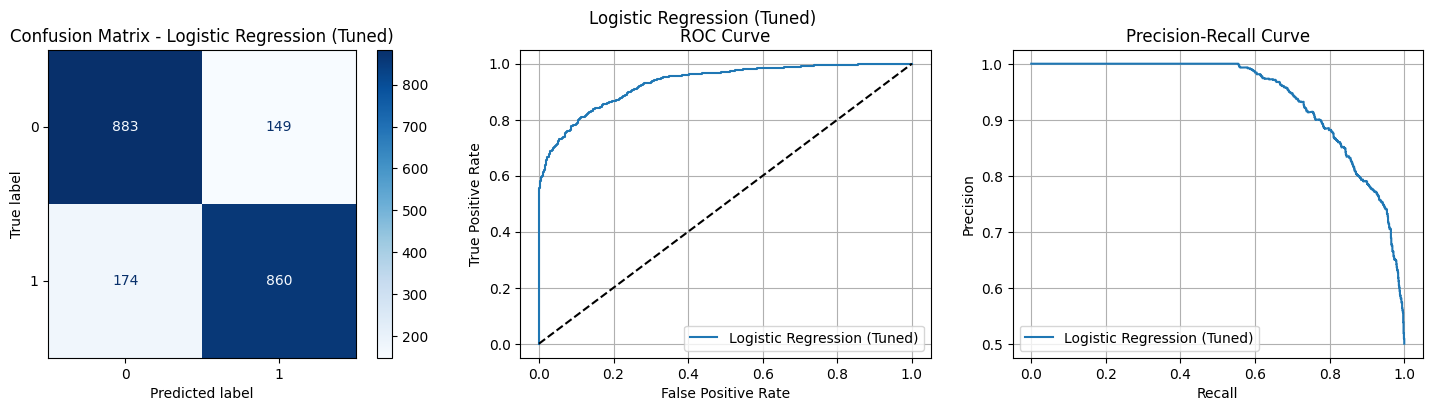

In [10]:
# plot_evaluation(y_test, y_prob, y_pred, 'Logistic Regression')
plot_evaluation(y_test, y_prob_best, y_pred_best, 'Logistic Regression (Tuned)')

In [11]:
model_scores = ['Logistic Regression', a, p, r, f1, ra, cva, cvp, cvr, cvf1, cvra]
model_scores_tuned = ['Logistic Regression (Tuned)', a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned, cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]

name = compare_models(model_scores, model_scores_tuned)
name

'Logistic Regression Performs better'

**Saving the trained model**

In [13]:
# Save the final model
if name == "Logistic Regression Performs better":
    eval_scores.loc[1] = ["Logistic Regression", a, p, r, f1, ra]
    cross_val_scores.loc[1] = ["Logistic Regression", cva, cvp, cvr, cvf1, cvra]
    joblib.dump(logreg, '../ml_models/logistic_regression_model.pkl')
else:
    eval_scores.loc[1] = ["Logistic Regression (Tuned)", a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned]
    cross_val_scores.loc[1] = ["Logistic Regression (Tuned)", cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]
    joblib.dump(logreg_tuned, '../ml_models/logistic_regression_tuned_model.pkl')

['../ml_models/logistic_regression_tuned_model.pkl']

## 2. Decision Trees

**Training the model**

In [14]:
dtree = DecisionTreeClassifier(random_state=200)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=200)

**Evaluate the performance of the model based on various metrics**
- **Accuracy, precision, recall, f1-score, ROC-AUC**
- **Generating Classification Report**
- **Confusion Matrix**
- **ROC Curve and Precision-Recall Curve**

In [15]:
y_pred, y_prob, table_data = evaluate_model(dtree, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.808325 │           0.797319 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.80381  │           0.797771 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.816248 │           0.791395 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.809981 │           0.783266 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.808318 │           0.798335 │
╘═══════════╧════════════════╧════════════════════╛


**Hyperparameter tuning using GridSearchCV**

In [16]:
# Hyperparameter Tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=200), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)

dtree_tuned = grid_search.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


**Evaluating the final model**

In [17]:
y_pred_best, y_prob_best, table_data = evaluate_model(dtree_tuned, X_test, y_test)

a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.819942 │           0.811069 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.808194 │           0.807488 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.839458 │           0.81309  │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.823529 │           0.802378 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.819923 │           0.887676 │
╘═══════════╧════════════════╧════════════════════╛


Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1032
           1       0.80      0.82      0.81      1034

    accuracy                           0.81      2066
   macro avg       0.81      0.81      0.81      2066
weighted avg       0.81      0.81      0.81      2066

Classification Report for Decision Tree (Tuned)
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1032
           1       0.81      0.84      0.82      1034

    accuracy                           0.82      2066
   macro avg       0.82      0.82      0.82      2066
weighted avg       0.82      0.82      0.82      2066



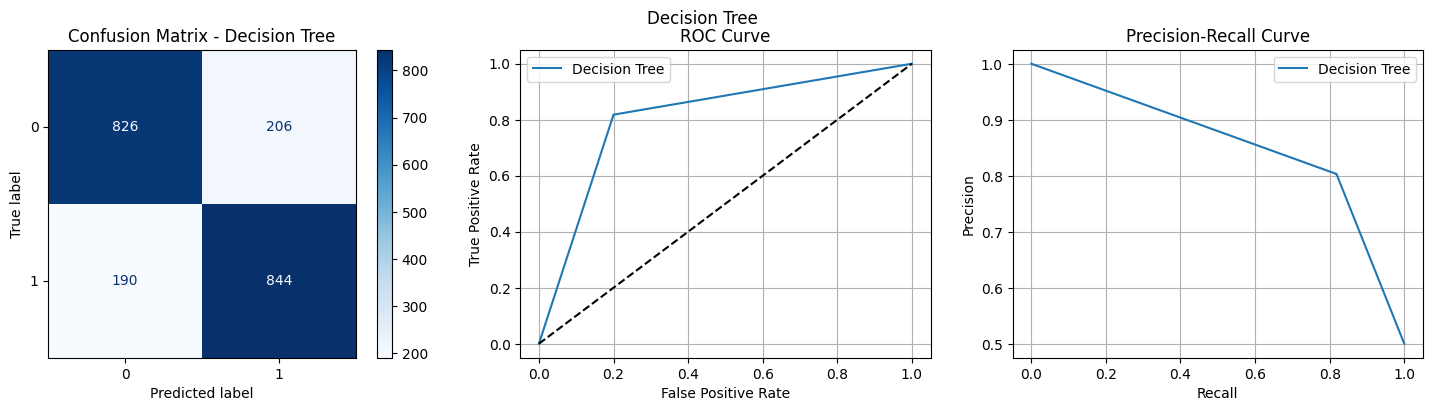

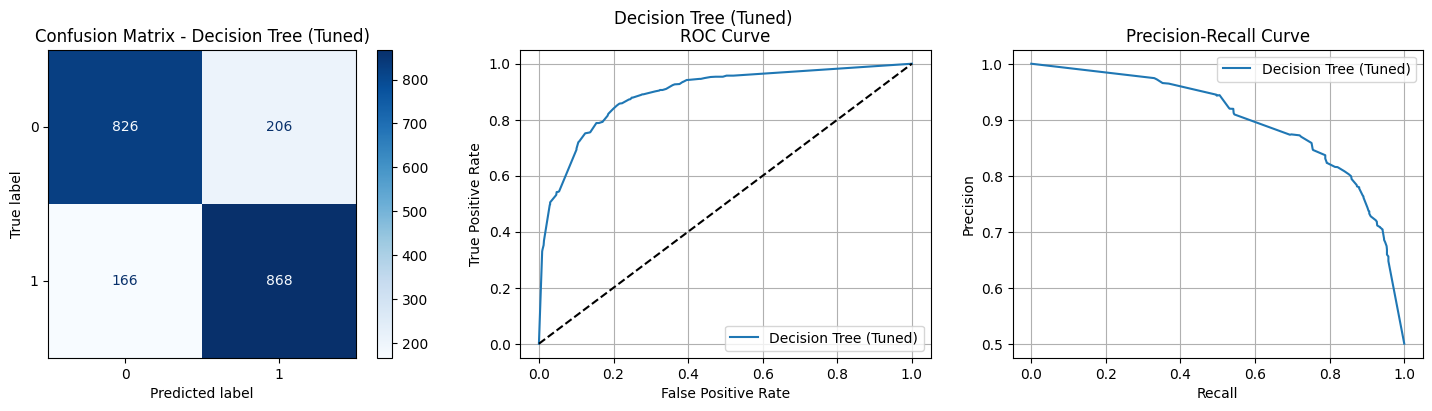

In [18]:
plot_evaluation(y_test, y_prob, y_pred, 'Decision Tree')
plot_evaluation(y_test, y_prob_best, y_pred_best, 'Decision Tree (Tuned)')

In [19]:
model_scores = ['Decision Tree', a, p, r, f1, ra, cva, cvp, cvr, cvf1, cvra]
model_scores_tuned = ['Decision Tree (Tuned)', a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned, cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]

name = compare_models(model_scores, model_scores_tuned)
name

'Decision Tree (Tuned) Performs better'

**Saving the trained model**

In [20]:
# Save the final model
if name == "Decision Tree Performs better":
    eval_scores.loc[2] = ["Decision Tree", a, p, r, f1, ra]
    cross_val_scores.loc[2] = ["Decision Tree", cva, cvp, cvr, cvf1, cvra]
    joblib.dump(dtree, '../ml_models/decision_tree_model.pkl')
else:
    eval_scores.loc[2] = ["Decision Tree (Tuned)", a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned]
    cross_val_scores.loc[2] = ["Decision Tree (Tuned)", cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]
    joblib.dump(dtree_tuned, '../ml_models/decision_tree_tuned_model.pkl')

## 3. Random Forest

**Training the model**

In [65]:
rf = RandomForestClassifier(random_state=200)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=200)

**Evaluate the performance of the model based on various metrics such as accuracy, precision, recall, and F1 score on single value and cross validation value**

In [66]:
y_pred, y_prob, table_data = evaluate_model(rf, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.85092  │           0.834799 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.857283 │           0.84616  │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.84236  │           0.815219 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.849756 │           0.817304 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.850928 │           0.93096  │
╘═══════════╧════════════════╧════════════════════╛


**Hyperparameter tuning using GridSearchCV**

In [67]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=200), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)

rf_tuned = grid_search.best_estimator_

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


**Evaluate the final model**

In [68]:
y_pred_best, y_prob_best, table_data = evaluate_model(rf_tuned, X_test, y_test)

a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.844627 │           0.836154 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.848485 │           0.84493  │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.839458 │           0.822385 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.843947 │           0.820549 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.844632 │           0.933098 │
╘═══════════╧════════════════╧════════════════════╛


Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1032
           1       0.86      0.84      0.85      1034

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066

Classification Report for Random Forest (Tuned)
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1032
           1       0.85      0.84      0.84      1034

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066



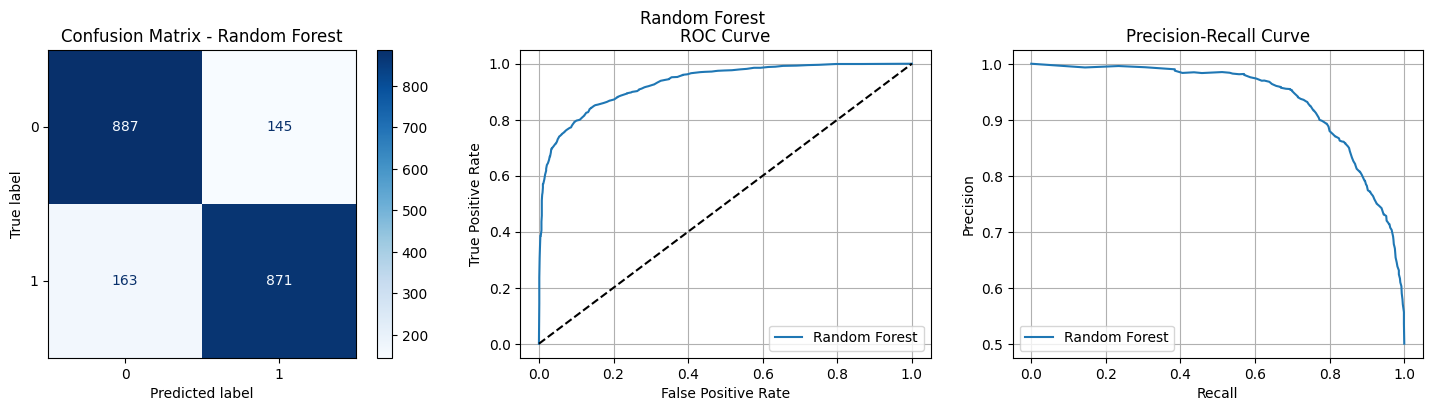

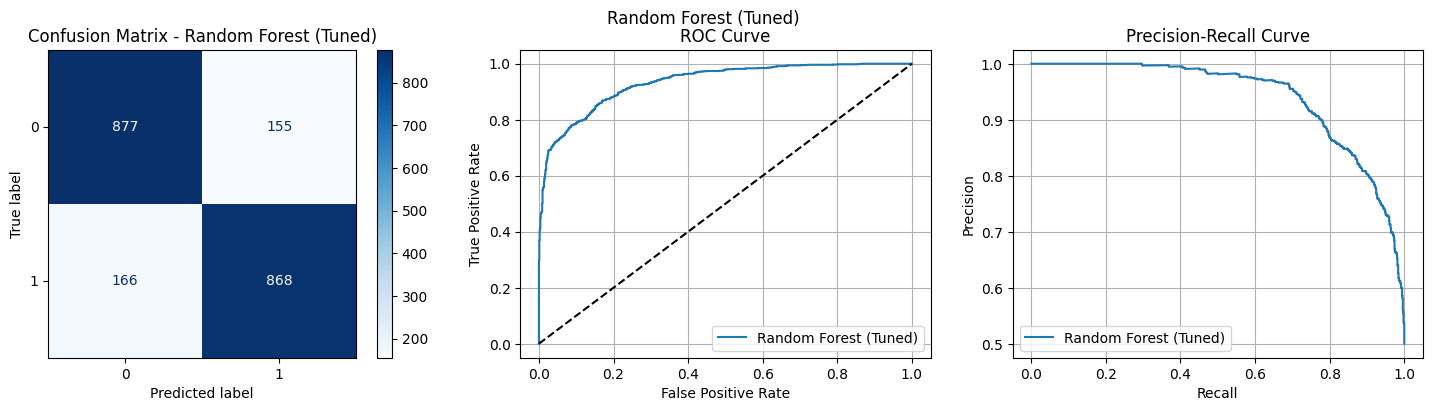

In [26]:
plot_evaluation(y_test, y_prob, y_pred, 'Random Forest')
plot_evaluation(y_test, y_prob_best, y_pred_best, 'Random Forest (Tuned)')

In [69]:
model_scores = ['Random Forest', a, p, r, f1, ra, cva, cvp, cvr, cvf1, cvra]
model_scores_tuned = ['Random Forest (Tuned)', a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned, cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]

name = compare_models(model_scores, model_scores_tuned)
name

'Random Forest Performs better'

**Saving the trained model**

In [72]:
# Save the final model
if name == "Random Forest Performs better":
    eval_scores.loc[3] = ["Random Forest", a, p, r, f1, ra]
    cross_val_scores.loc[3] = ["Random Forest", cva, cvp, cvr, cvf1, cvra]
    joblib.dump(rf, '../ml_models/random_forest_model.pkl')
else:
    eval_scores.loc[3] = ["Random Forest (Tuned)", a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned]
    cross_val_scores.loc[3] = ["Random Forest (Tuned)", cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]
    joblib.dump(rf_tuned, '../ml_models/random_forest_tuned_model.pkl')

['../ml_models/random_forest_tuned_model.pkl']

## 4. Gradient Boosting

In [29]:
gb = GradientBoostingClassifier(random_state=200)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=200)

In [30]:
y_pred, y_prob, table_data = evaluate_model(gb, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.85334  │           0.835185 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.843838 │           0.837872 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.867505 │           0.830132 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.855508 │           0.822532 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.853326 │           0.931717 │
╘═══════════╧════════════════╧════════════════════╛


In [31]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)

gb_tuned = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [32]:
y_pred_best, y_prob_best, table_data = evaluate_model(gb_tuned, X_test, y_test)

a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.849468 │           0.837414 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.848602 │           0.849279 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.851064 │           0.818899 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.849831 │           0.819798 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.849466 │           0.934537 │
╘═══════════╧════════════════╧════════════════════╛


Classification Report for Gradient Boosting
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1032
           1       0.84      0.87      0.86      1034

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066

Classification Report for Gradient Boosting (Tuned)
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1032
           1       0.85      0.85      0.85      1034

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



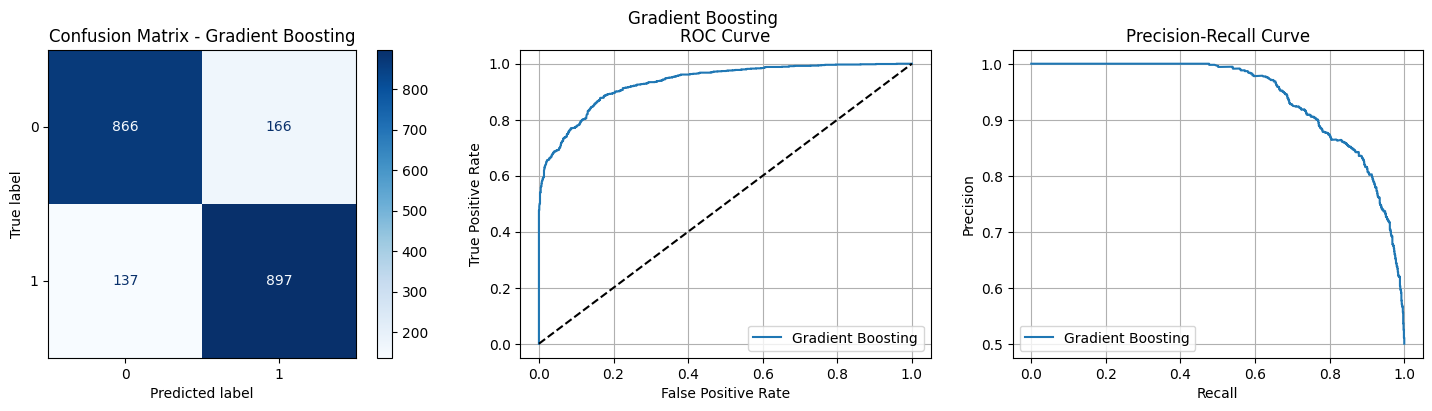

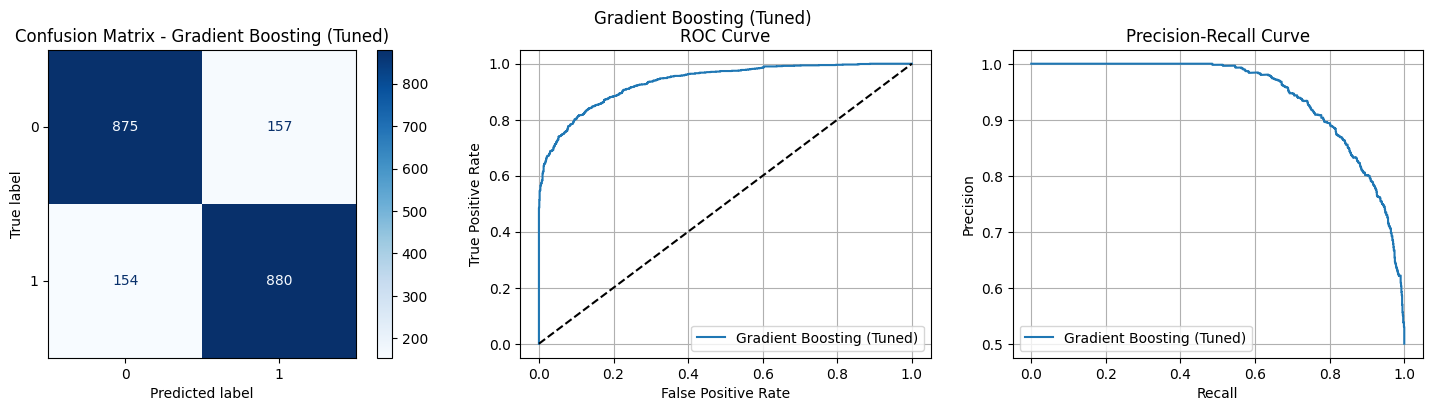

In [33]:
plot_evaluation(y_test, y_prob, y_pred, 'Gradient Boosting')
plot_evaluation(y_test, y_prob_best, y_pred_best, 'Gradient Boosting (Tuned)')

In [73]:
model_scores = ['Gradient Boosting', a, p, r, f1, ra, cva, cvp, cvr, cvf1, cvra]
model_scores_tuned = ['Gradient Boosting (Tuned)', a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned, cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]

name = compare_models(model_scores, model_scores_tuned)
name

'Gradient Boosting Performs better'

In [74]:
# Save the final model
if name == "Gradient Boosting Performs better":
    eval_scores.loc[4] = ["Gradient Boosting", a, p, r, f1, ra]
    cross_val_scores.loc[4] = ["Gradient Boosting", cva, cvp, cvr, cvf1, cvra]
    joblib.dump(gb, '../ml_models/gradient_boosting_model.pkl')
else:
    eval_scores.loc[4] = ["Gradient Boosting (Tuned)", a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned]
    cross_val_scores.loc[4] = ["Gradient Boosting (Tuned)", cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]
    joblib.dump(gb_tuned, '../ml_models/gradient_boosting_tuned_model.pkl')

['../ml_models/gradient_boosting_tuned_model.pkl']

## 5. Support Vector Machines

In [36]:
svm = SVC(probability=True, random_state=200)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=200)

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.669894 │           0.662211 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.682573 │           0.677478 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.636364 │           0.619602 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.658659 │           0.647184 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.669926 │           0.742601 │
╘═══════════╧════════════════╧════════════════════╛
Classification Report for Support Vector Machine
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1032
           1       0.68      0.64      0.66      1034

    accuracy                           0.67      2066
   macro avg       0.67      0.67      0.67      2066
wei

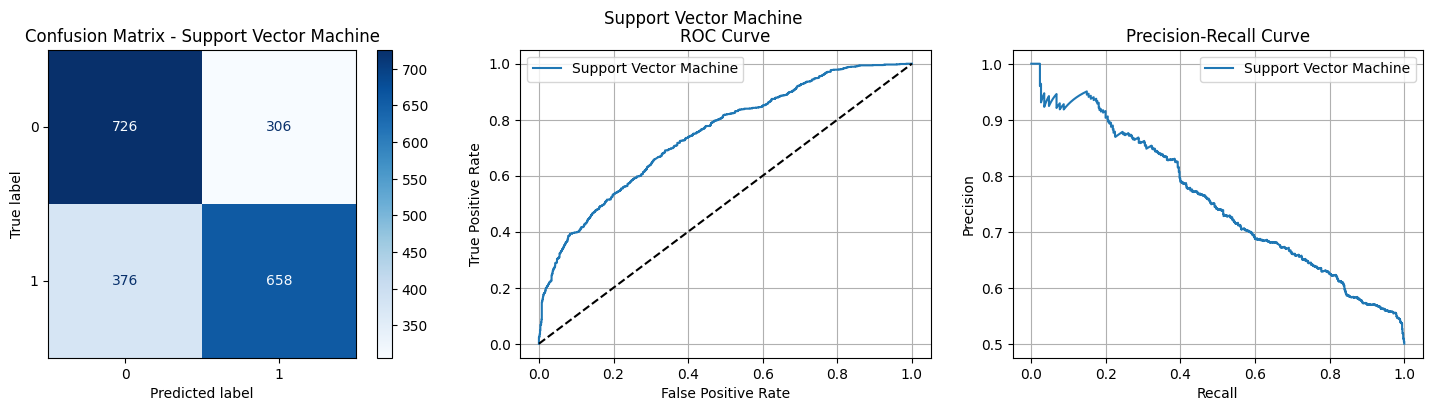

In [37]:
y_pred, y_prob, table_data = evaluate_model(svm, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

plot_evaluation(y_test, y_prob, y_pred, 'Support Vector Machine')

In [38]:
eval_scores.loc[5] = ["Support Vector Machine", a, p, r, f1, ra]
cross_val_scores.loc[5] = ["Support Vector Machine", cva, cvp, cvr, cvf1, cvra]
joblib.dump(svm, '../ml_models/support_vector_machine_model.pkl')

['../ml_models/support_vector_machine_model.pkl']

## 6. XGBoost

In [39]:
xgboost = xgb.XGBClassifier(random_state=200)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=200, ...)

In [40]:
y_pred, y_prob, table_data = evaluate_model(xgboost, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.839303 │           0.83267  │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.840116 │           0.848004 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.838491 │           0.806309 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.839303 │           0.809828 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.839304 │           0.929974 │
╘═══════════╧════════════════╧════════════════════╛


In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
}

grid_search = GridSearchCV(xgb.XGBClassifier(random_state=200), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)

xgboost_tuned = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [42]:
y_pred_best, y_prob_best, table_data = evaluate_model(xgboost_tuned, X_test, y_test)

a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.840755 │           0.83722  │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.842566 │           0.849317 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.838491 │           0.817542 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.840524 │           0.81854  │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.840757 │           0.936166 │
╘═══════════╧════════════════╧════════════════════╛


Classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1032
           1       0.84      0.84      0.84      1034

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066

Classification Report for XGBoost (Tuned)
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1032
           1       0.84      0.84      0.84      1034

    accuracy                           0.84      2066
   macro avg       0.84      0.84      0.84      2066
weighted avg       0.84      0.84      0.84      2066



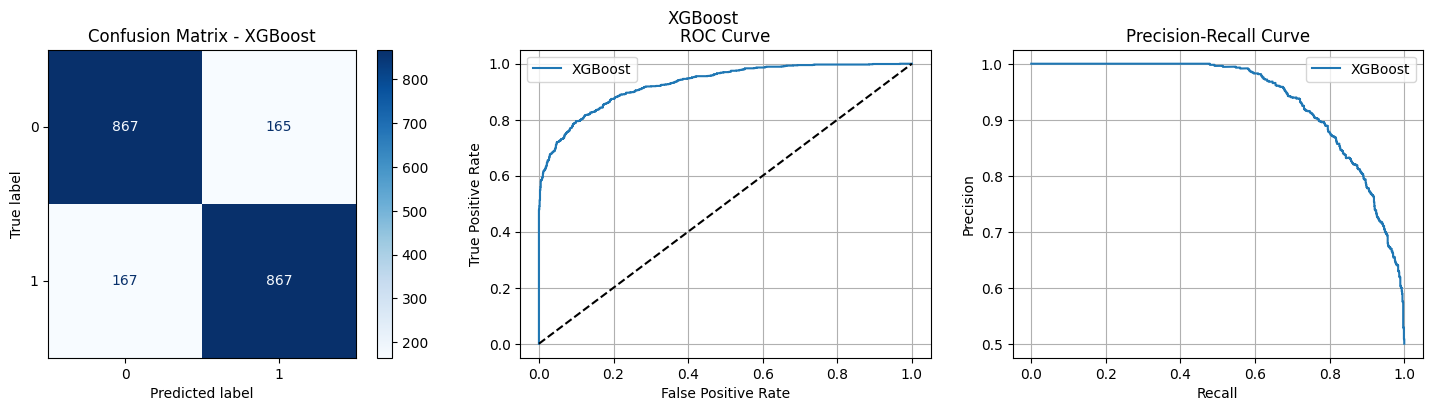

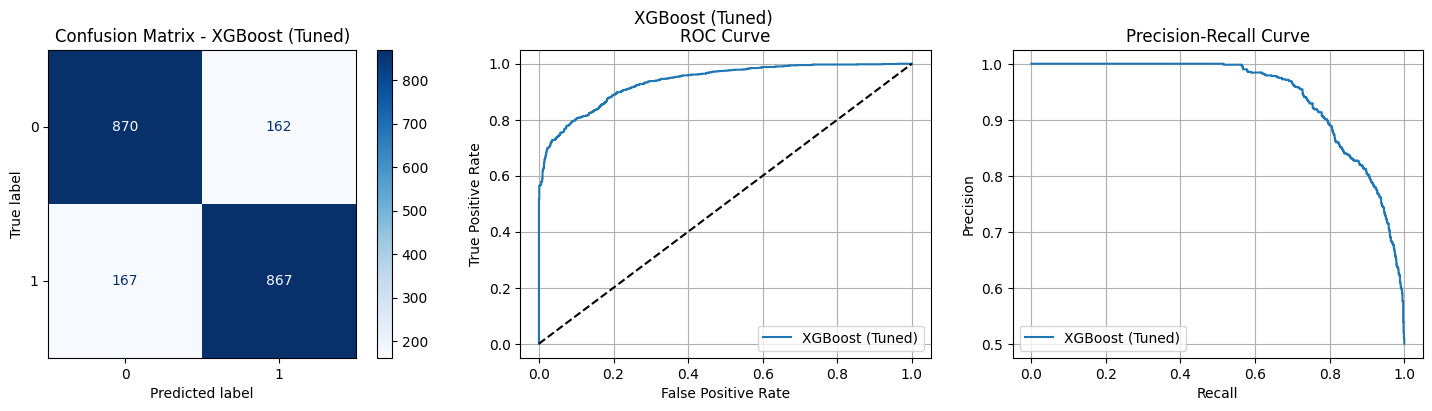

In [43]:
plot_evaluation(y_test, y_prob, y_pred, 'XGBoost')
plot_evaluation(y_test, y_prob_best, y_pred_best, 'XGBoost (Tuned)')

In [44]:
model_scores = ['XGBoost', a, p, r, f1, ra, cva, cvp, cvr, cvf1, cvra]
model_scores_tuned = ['XGBoost (Tuned)', a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned, cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]

name = compare_models(model_scores, model_scores_tuned)
name

'XGBoost (Tuned) Performs better'

In [45]:
# Save the final model
if name == "XGBoost Performs better":
    eval_scores.loc[6] = ["XGBoost", a, p, r, f1, ra]
    cross_val_scores.loc[6] = ["XGBoost", cva, cvp, cvr, cvf1, cvra]
    joblib.dump(xgboost, '../ml_models/xgboost_model.pkl')
else:
    eval_scores.loc[6] = ["XGBoost (Tuned)", a_tuned, p_tuned, r_tuned, f1_tuned, ra_tuned]
    cross_val_scores.loc[6] = ["XGBoost (Tuned)", cva_tuned, cvp_tuned, cvr_tuned, cvf1_tuned, cvra_tuned]
    joblib.dump(xgboost_tuned, '../ml_models/xgboost_tuned_model.pkl')

## 7. Voting Classifier

In [58]:
with open('../ml_models/logistic_regression_model.pkl', 'rb') as f:
    logreg_tuned = joblib.load(f)

with open('../ml_models/decision_tree_tuned_model.pkl', 'rb') as f:
    dtree_tuned = joblib.load(f)

with open('../ml_models/random_forest_model.pkl', 'rb') as f:
    rf_tuned = joblib.load(f)

with open('../ml_models/gradient_boosting_model.pkl', 'rb') as f:
    gb_tuned = joblib.load(f)

# with open('../ml_models/support_vector_machine_model.pkl', 'rb') as f:
#     svm = joblib.load(f)

with open('../ml_models/xgboost_tuned_model.pkl', 'rb') as f:
    xgboost_tuned = joblib.load(f)

voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg_tuned),
    ('dtree', dtree_tuned),
    ('rf', rf_tuned),
    ('gb', gb_tuned),
    # ('svm', svm),
    ('xgboost', xgboost_tuned)
], voting='soft')

voting_clf.fit(X_train, y_train)

/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('logreg',
                              LogisticRegression(max_iter=1000,
                                                 random_state=200)),
                             ('dtree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_leaf=4,
                                                     random_state=200)),
                             ('rf', RandomForestClassifier(random_state=200)),
                             ('gb',
                              GradientBoostingClassifier(random_state=200)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            ca...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=200, ...))],
                 voting='soft')

/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/am07127/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

╒═══════════╤════════════════╤════════════════════╕
│ Metric    │   Single Value │   Cross Validation │
╞═══════════╪════════════════╪════════════════════╡
│ Accuracy  │       0.852856 │           0.840802 │
├───────────┼────────────────┼────────────────────┤
│ Precision │       0.846958 │           0.845789 │
├───────────┼────────────────┼────────────────────┤
│ Recall    │       0.861702 │           0.832455 │
├───────────┼────────────────┼────────────────────┤
│ F1 Score  │       0.854267 │           0.827069 │
├───────────┼────────────────┼────────────────────┤
│ ROC AUC   │       0.852847 │           0.937134 │
╘═══════════╧════════════════╧════════════════════╛
Classification Report for Voting Classifier
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1032
           1       0.85      0.86      0.85      1034

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted

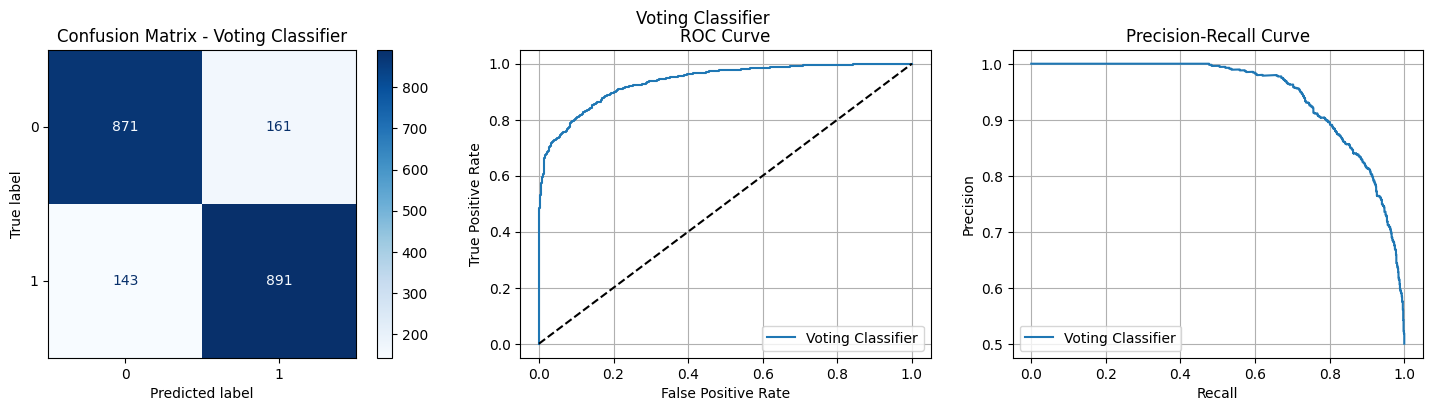

In [59]:
y_pred, y_prob, table_data = evaluate_model(voting_clf, X_test, y_test)

a, p, r, f1, ra = table_data[1][1], table_data[2][1], table_data[3][1], table_data[4][1], table_data[5][1]
cva, cvp, cvr, cvf1, cvra = table_data[1][2], table_data[2][2], table_data[3][2], table_data[4][2], table_data[5][2]

plot_evaluation(y_test, y_prob, y_pred, 'Voting Classifier')

In [61]:
eval_scores.loc[7] = ["Voting Classifier", a, p, r, f1, ra]
cross_val_scores.loc[7] = ["Voting Classifier", cva, cvp, cvr, cvf1, cvra]
joblib.dump(voting_clf, '../ml_models/voting_classifier_model.pkl')

['../ml_models/voting_classifier_model.pkl']

In [62]:
eval_scores.to_csv('eval_scores2.csv', index=False)
cross_val_scores.to_csv('cross_val_scores2.csv', index=False)

In [ ]:
eval_scores = pd.read_csv('eval_scores.csv')
cross_val_scores = pd.read_csv('cross_val_scores.csv')

## Final Model Selection

We rank each model based on their final performance scores and cross-validation scores and select the 2 models with the top ranks as the final models. 

We see that the **Voting Classifier** model overall has the highest scores for all the metrics for both single value and cross-validation value. 
The **XGBoost (Tuned)** model also has good scores much similar to the **Voting Classifier** model. However, for finding the prediction results, the **Random Forest (Tuned)** model surprisingly gave the best results, and also has good scores overall for all the metrics, ranking third in Cross-Validation scores.

In [63]:
ranked_models = cross_val_scores.set_index('Model')
ranked_models['Rank'] = ranked_models.mean(axis=1).rank(ascending=False)
ranked_models.sort_values('Rank', ascending=True, inplace=True)
ranked_models

,CV - Accuracy,CV - Precision,CV - Recall,CV - F1,CV - ROC AUC,Rank
Model,,,,,,
Voting Classifier,0.840802,0.845789,0.832455,0.827069,0.937134,1.0
XGBoost (Tuned),0.837220,0.849317,0.817542,0.818540,0.936166,2.0
Gradient Boosting,0.835185,0.837872,0.830132,0.822532,0.931717,3.0
Random Forest,0.834799,0.846160,0.815219,0.817304,0.930960,4.0
Logistic Regression,0.831505,0.851014,0.803016,0.811780,0.931525,5.0
Decision Tree (Tuned),0.811069,0.807488,0.813090,0.802378,0.887676,6.0
Support Vector Machine,0.662211,0.677478,0.619602,0.647184,0.742601,7.0


In [64]:
ranked_single = eval_scores.set_index('Model')
ranked_single['Rank'] = ranked_single.mean(axis=1).rank(ascending=False)
ranked_single.sort_values('Rank', ascending=True, inplace=True)
ranked_single

,Accuracy,Precision,Recall,F1,ROC AUC,Rank
Model,,,,,,
Gradient Boosting,0.853340,0.843838,0.867505,0.855508,0.853326,1.0
Voting Classifier,0.852856,0.846958,0.861702,0.854267,0.852847,2.0
Random Forest,0.850920,0.857283,0.842360,0.849756,0.850928,3.0
Logistic Regression,0.843175,0.849409,0.834623,0.841951,0.843184,4.0
XGBoost (Tuned),0.840755,0.842566,0.838491,0.840524,0.840757,5.0
Decision Tree (Tuned),0.819942,0.808194,0.839458,0.823529,0.819923,6.0
Support Vector Machine,0.669894,0.682573,0.636364,0.658659,0.669926,7.0


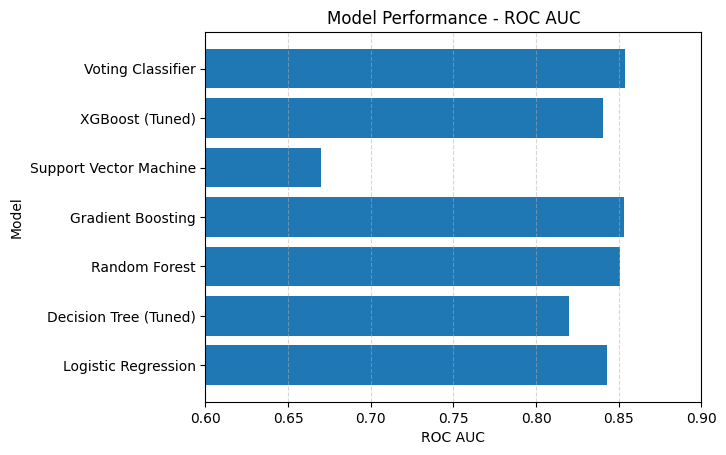

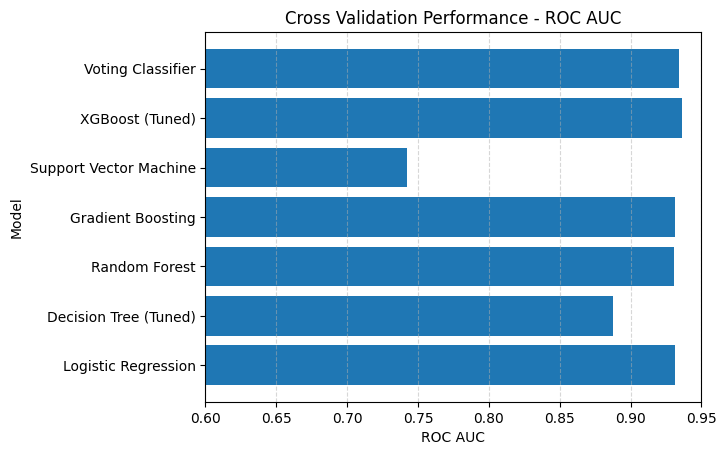

In [55]:
plt.barh(eval_scores['Model'], eval_scores['ROC AUC'])
plt.xlabel('ROC AUC')
plt.ylabel('Model')
plt.title('Model Performance - ROC AUC')
plt.xlim(0.6, 0.9)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

plt.barh(cross_val_scores['Model'], cross_val_scores['CV - ROC AUC'])
plt.xlabel('ROC AUC')
plt.ylabel('Model')
plt.title('Cross Validation Performance - ROC AUC')
plt.xlim(0.6, 0.95)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## Interpreting the Results

The results using SHAP show that the Monthly Charges, and Contract for Two years, had the most significant impact on the model's predictions. This is followed by Gender - which is quite interesting as according to our EDA, both the genders had almost equal churn rates. The internet services had the least impact on the model's predictions, with Device Protection having the least impact.

PermutationExplainer explainer: 10327it [13:25:07,  4.68s/it]                            


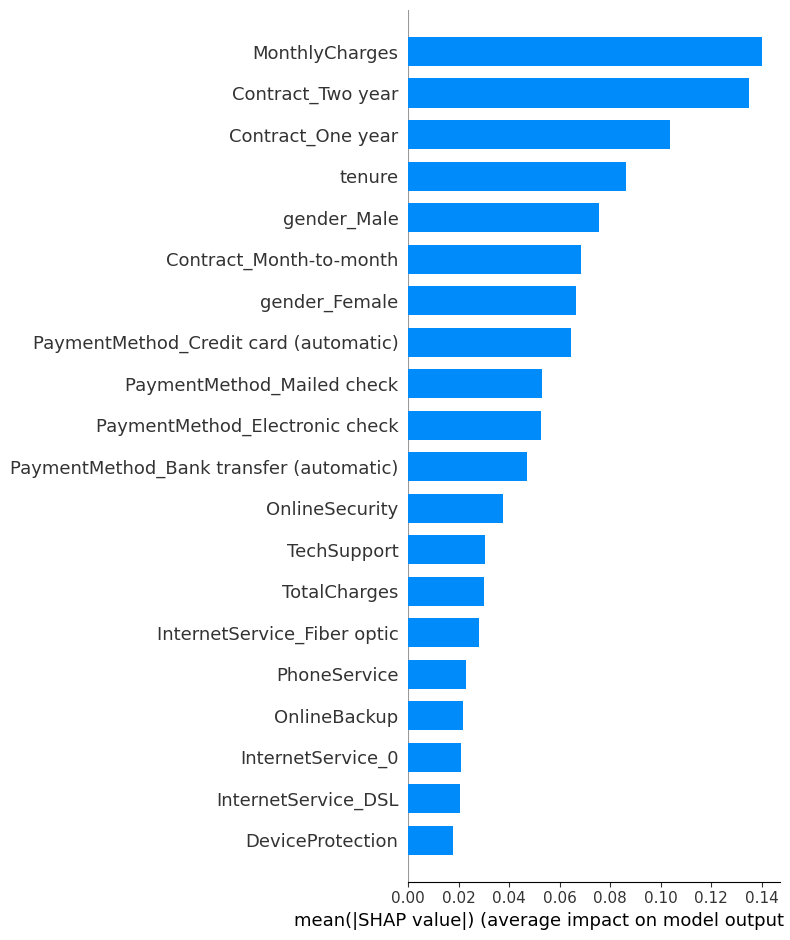

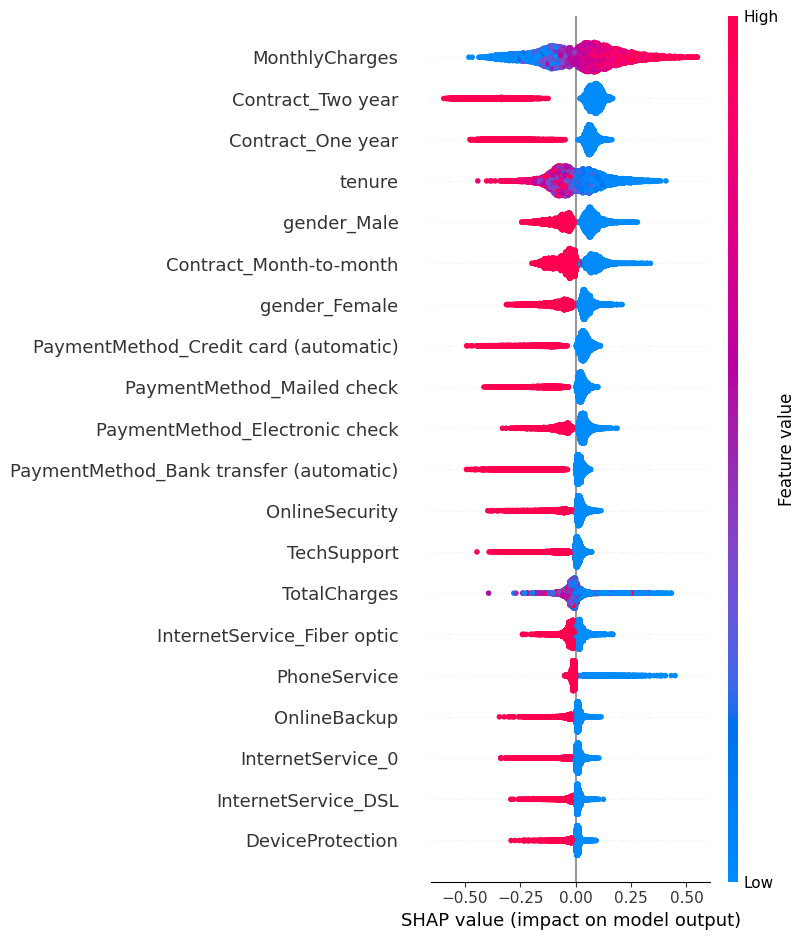

In [56]:
with open('../ml_models/voting_classifier_model.pkl', 'rb') as f:
    voting_clf = joblib.load(f)

data = pd.read_csv('../data/processed_data_ml_model.csv')

ex = data.drop(columns=['Churn'])

explainer = shap.Explainer(voting_clf.predict, ex)
shap_values = explainer.shap_values(ex)

shap.summary_plot(shap_values, ex, plot_type='bar')

shap.summary_plot(shap_values, ex)